In [2]:
#Importo las librerías necesarias
from sklearn.preprocessing import MinMaxScaler

import numpy as np
#Semilla para asegurar valores aleatorios
np.random.seed(10)

import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers

Cargo los datos, luego los separo por entradas y los normalizo

In [3]:
data = pd.read_csv("D:\\Programas\\OneDrive - Estudiantes ITCR\\TEC\\Semestre 9\\IA\\Tareas\\Tarea1_IA\\ParteA\\synchronous machine.csv", sep=';')

X=data[["Iy", "PF", "e", "dIf"]]
y=data[["If"]]
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(X)
X_data = scaler1.transform(X)

scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2.fit(y)
y_data = scaler2.transform(y)

Divido los datos en datos de entrenamiento y datos de testeo
60% entrenamiento, 40% para test

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

Las siguientes funciones sirven para imprimir la curva de aprendizaje de la red

In [5]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.7])
  plt.legend()
  plt.show()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.7])
  plt.legend()
  plt.show()

Se definen los parámetros de la red neuronal

In [31]:
model = keras.Sequential([
  layers.Dense(4, activation='sigmoid', input_shape=[4]), #Número de entradas
  layers.Dense(4, activation='sigmoid'),
  layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001) #Define el optimizador

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
               metrics=['accuracy', "mae", "mse"])


Entreno el modelo e imprimo la curva de aprendizaje

Epoch 1/1000
1/1 [==============================] - 1s 930ms/step - loss: 0.0355 - accuracy: 0.0030 - mae: 0.2180 - mse: 0.0710 - val_loss: 0.0286 - val_accuracy: 0.0090 - val_mae: 0.1963 - val_mse: 0.0572
Epoch 2/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0349 - accuracy: 0.0030 - mae: 0.2166 - mse: 0.0698 - val_loss: 0.0282 - val_accuracy: 0.0090 - val_mae: 0.1954 - val_mse: 0.0564
Epoch 3/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.0343 - accuracy: 0.0030 - mae: 0.2153 - mse: 0.0687 - val_loss: 0.0278 - val_accuracy: 0.0090 - val_mae: 0.1945 - val_mse: 0.0557
Epoch 4/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0338 - accuracy: 0.0030 - mae: 0.2141 - mse: 0.0676 - val_loss: 0.0275 - val_accuracy: 0.0090 - val_mae: 0.1937 - val_mse: 0.0550
Epoch 5/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0333 - accuracy: 0.0030 - mae: 0.2130 - mse: 0.0665 - val_loss: 0.0272 - val_accuracy: 0.0090 - val_mae:

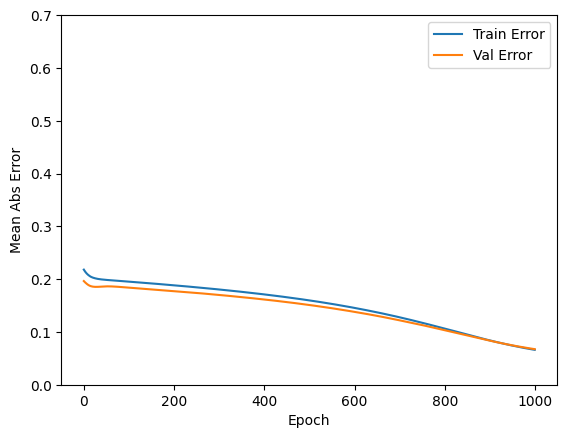

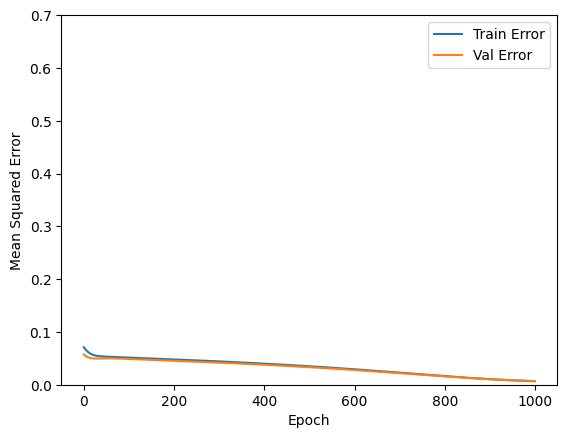

In [32]:
history = model.fit(X_train,y_train,
                    validation_data=(X_test, y_test),
                    epochs = 1000,
                    batch_size=512, 
                    verbose = 1, 
                    callbacks = [PrintDot()])

plot_history(history)

In [33]:
# Se serializa el modelo en formato JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

# Se serializan los pesos a formato HDF5
model.save_weights("model.h5")
print("Modelo Guardado!")

Modelo Guardado!


A partir de este punto está el código de implementación de la red

Alimento el modelo ya entrenado con las 80 combinaciones de entradas para el punto 3 A

In [34]:

prueba = pd.read_csv("datos_combinaciones.csv")

model.predict(prueba)

3/3 [==============================] - 0s 3ms/step


array([[0.5494727 ],
       [0.6130006 ],
       [0.670262  ],
       [0.5669533 ],
       [0.62881964],
       [0.684162  ],
       [0.594657  ],
       [0.6536679 ],
       [0.7057976 ],
       [0.5201958 ],
       [0.5878782 ],
       [0.64930314],
       [0.538264  ],
       [0.6043368 ],
       [0.66382265],
       [0.56706107],
       [0.63033324],
       [0.6865531 ],
       [0.46910968],
       [0.5434602 ],
       [0.6120608 ],
       [0.487941  ],
       [0.56084883],
       [0.6275183 ],
       [0.51821566],
       [0.58854306],
       [0.6519232 ],
       [0.63372767],
       [0.6754643 ],
       [0.7149656 ],
       [0.64694417],
       [0.6878473 ],
       [0.7263101 ],
       [0.6679716 ],
       [0.70738167],
       [0.7440152 ],
       [0.61428404],
       [0.65837294],
       [0.69997925],
       [0.6278465 ],
       [0.671105  ],
       [0.7116887 ],
       [0.64955103],
       [0.6913215 ],
       [0.73009384],
       [0.5803542 ],
       [0.628657  ],
       [0.674

Punto 3 B: utilización del modelo para realizar una clasificación tipo Ceteris Paribus en un conjunto de datos generados manualmente al variar en 5%, 10%, 20%, 40% y 60% cada uno de los datos de las columnas individualmente.

In [35]:
prueba = pd.read_csv("DatosParaCeterisParibus.csv")
#prueba = mean_norm(prueba)
model.predict(prueba)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_5/dense_15/BiasAdd' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\Programas\Python\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "d:\Programas\Python\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "d:\Programas\Python\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "d:\Programas\Python\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_11132\390129956.py", line 3, in <module>
      model.predict(prueba)
    File "d:\Programas\Python\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Programas\Python\Lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "d:\Programas\Python\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "d:\Programas\Python\Lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Programas\Python\Lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "d:\Programas\Python\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "d:\Programas\Python\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Programas\Python\Lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\Programas\Python\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Programas\Python\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Programas\Python\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Programas\Python\Lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "d:\Programas\Python\Lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\Programas\Python\Lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\Programas\Python\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Programas\Python\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Programas\Python\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Programas\Python\Lib\site-packages\keras\layers\core\dense.py", line 252, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'sequential_5/dense_15/BiasAdd'
Matrix size-incompatible: In[0]: [20,1], In[1]: [4,4]
	 [[{{node sequential_5/dense_15/BiasAdd}}]] [Op:__inference_predict_function_404815]